In [10]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

<xarray.Dataset> Size: 60kB
Dimensions:      (depth_index: 579, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 5kB 1 2 3 4 5 6 ... 574 575 576 577 578 579
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 56kB ...

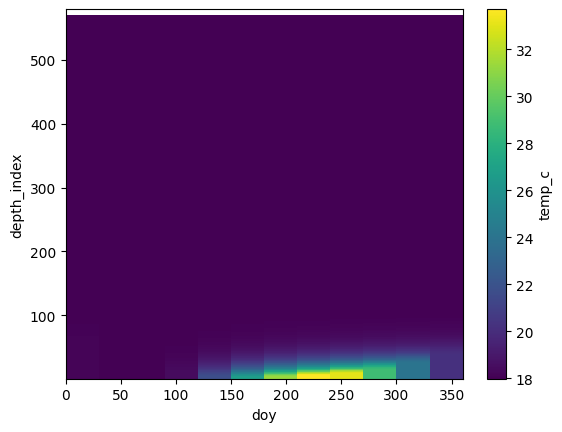

In [11]:
# Load lake data
lakedata =  xr.open_dataset('_test_prof (1).nc')
lakedata['temp_c'].plot()
lakedata

In [12]:
def clumped_sensor(temp_c, model):
        if model == 'I-CDES90':
            cap47 = 0.0004 * 10**6 / (temp_c + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            cap47 = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return cap47 # returns model eq back to caller (clumped_sensor)

In [13]:
def generate_weights(depth, weight_type): #add so that it adds weights to doy too based off notes (for loop?)
    """
    Generate a depth-weighting function.

    Args:
        depths (np.ndarray or pd.Series): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == 'uniform':
        weights = np.repeat(1 / len(depth), len(depth))
    
    elif weight_type == 'surface':
        weights = np.array([1] + [0] * (len(depth) - 1))
    
    elif weight_type == 'normal_dist':
        depth_index_mean = round(depth.values.mean(), 2)
        depth_index_std = round(depth.values.std(), 2)
        weights = (1 / (depth_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depth - depth_index_mean) / depth_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError('Weight type not recognized')
    
    return weights



In [14]:
MAMJ = range(60, 182), # March to June
AMJ = range(91, 182), # April to June  
AMJJ = range(91, 213), # April to July
AMJJASO = range(91, 305), # April to October
JJA = range(152, 244), # July to August 
ASO = range(213, 305), # August to October
January = range(0, 32),
February = range(32, 60),
March = range(60, 91),
April = range(91, 121),
May = range(121, 152),
June = range(152, 182),
July = range(182, 213),
August = range(213, 244),
September = range(244, 274),
October = range(274, 305),
November = range(305, 335),
December = range(335, 366)

       temp_c_wtd_mean  cap47_wtd_mean
doy                                   
345.0        20.151111        0.158650
315.0        24.041000        0.158529
285.0        28.853000        0.158386
255.0        33.060000        0.158266
225.0        33.713000        0.158248
195.0        31.303000        0.158315
165.0        26.726000        0.158448
135.0        21.685000        0.158602
105.0        18.428000        0.158705
75.0         17.990000        0.158719
45.0         17.990000        0.158719


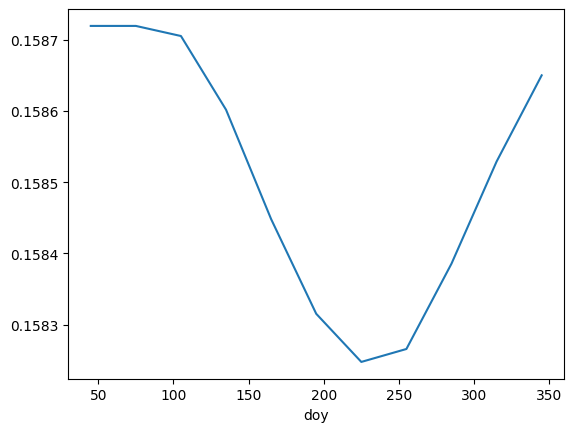

In [19]:
#w/o time weights
timesteps = lakedata['doy'].values
depth = pd.DataFrame(lakedata['depth_index'])

for ts in timesteps:
   tmpds = lakedata.sel(doy = ts) # pull out this timestep
   tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df
    
   temp_c = tmpdf['temp_c'] # why can't I do the same thing with tmpdf['depth_index']? Will calling it from up there work if depth changes over time? I don't think so
     
   cap47 = clumped_sensor(temp_c, 'I-CDES90')
   depth_weights = generate_weights(depth, 'normal_dist')  
    
   if ts == timesteps[0]:
      df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
        
   else:
      tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])

      cap47_wtd_mean = (cap47 * depth_weights).sum()  / depth_weights.sum()
      temp_c_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
        
      tdf = tdf.assign(temp_c_wtd_mean = temp_c_wtd_mean)
      tdf = tdf.assign(cap47_wtd_mean = cap47_wtd_mean)
      df = pd.concat([tdf, df], ignore_index=True)
      df = df.dropna()      

df = df.set_index('doy', drop=True)
fig1 = df['cap47_wtd_mean']
fig1.plot()
print(df)

In [1]:
fig2 = df['temp_c_wtd_mean']
fig2.plot()

NameError: name 'df' is not defined

In [ ]:
timesteps = df['doy']

for ts in (timesteps) :
    ds = df.sel(doy = ts) # pull out this timestep
    #df = ds.to_dataframe().reset_index()  # convert it back to pandas df
    
    time_weights = generate_weights(timesteps, 'normal_dist')  

    df['cap47_wtd_mean'] = (df['cap47_wtd_mean'] * time_weights)
    df['temp_c_wtd_mean'] = (df['temp_c_wtd_mean'] * time_weights)  

fig1 = df['cap47_wtd_mean']
fig1.plot()

<Axes: xlabel='doy'>

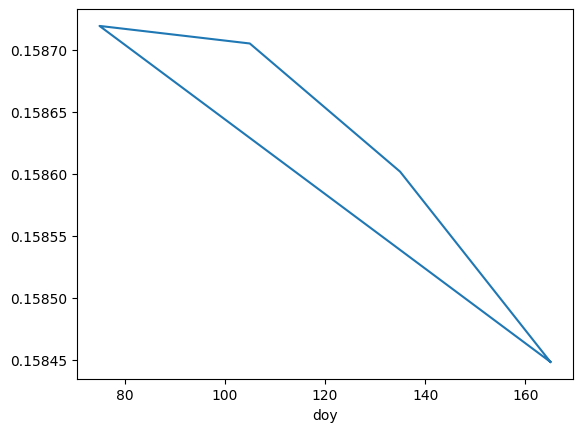

In [ ]:
#w/ time weights
timesteps = lakedata['doy'].values
depth = pd.DataFrame(lakedata['depth_index'])

for ts in timesteps:
     if ts in MAMJ[0]:
        tmpds = lakedata.sel(doy = ts) # pull out this timestep
        tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df
    
        temp_c = tmpdf['temp_c'] # why can't I do the same thing with tmpdf['depth_index']? Will calling it from up there work if depth changes over time? I don't think so
     
        cap47 = clumped_sensor(temp_c, 'I-CDES90')
        depth_weights = generate_weights(depth, 'normal_dist')  
    
     if ts == timesteps[0]:
         df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
        
     else:
         tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])

         cap47_wtd_mean = (cap47 * depth_weights).sum()  / depth_weights.sum()
         temp_c_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
        
         tdf = tdf.assign(temp_c_wtd_mean = temp_c_wtd_mean)
         tdf = tdf.assign(cap47_wtd_mean = cap47_wtd_mean)
         df = pd.concat([tdf, df], ignore_index=True)
         df = df.dropna()      


df = df.set_index('doy', drop=True)
fig1 = df['cap47_wtd_mean']
fig1.plot()